# Convolutional NN

In [ ]:
!pip install torch
!pip install torchvision

In [58]:
import torch
import torchvision
import torch.nn as nn
import torch.nn.functional as F
from torch.optim import Adam
from torch.utils.data import DataLoader
from torchvision import transforms
import numpy as np
from torch.utils.data import random_split
import warnings
warnings.filterwarnings('ignore')
from sklearn.metrics import classification_report,accuracy_score,f1_score
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report,accuracy_score,confusion_matrix,f1_score,ConfusionMatrixDisplay
from sklearn.metrics import plot_confusion_matrix

## Dataset

In [2]:
transformer = transforms.Compose([
                               torchvision.transforms.ToTensor(),
                             ])

In [3]:
train_set=torchvision.datasets.FashionMNIST('./files/fashion-mnist/', train=True, download=True,
                             transform=transformer)

test_set=torchvision.datasets.FashionMNIST('./files/fashion-mnist/', train=False, download=True,
                             transform=transformer)

batch_size_train = 128
batch_size_test = 128

In [ ]:
train_loader = torch.utils.data.DataLoader(
  train_set,
  batch_size=batch_size_train, shuffle=True)

test_loader = torch.utils.data.DataLoader(
  test_set,
  batch_size=batch_size_test, shuffle=True)

In [ ]:
train_enumerated = enumerate(train_loader)
batch_idx, (train_x, train_y) = next(train_enumerated)

test_enumerated = enumerate(test_loader)
batch_idx, (test_x, test_y) = next(test_enumerated)

In [ ]:
train_x.shape

torch.Size([128, 1, 28, 28])

In [ ]:
train_x[1].shape

torch.Size([1, 28, 28])

In [ ]:
train_x[1]

tensor([[[0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,

In [45]:
classes = [ 'T-shirt/top',
 'Trouser',
 'Pullover',
 'Dress',
 'Coat',
 'Sandal',
 'Shirt',
 'Sneaker',
 'Bag',
'Ankle boot']

In [ ]:
def print_white_black_image(images,ys):
    num_row = 3
    num_col = 5
    
    images = [img[0, :, :] for img in images]
    labels = [classes[label] for label in ys]

    fig, axes = plt.subplots(num_row, num_col, figsize=(1.5*num_col,2*num_row))
    for i in range(num_row*num_col):
        ax = axes[i//num_col, i%num_col]
        ax.imshow(images[i], cmap='gray')
        ax.set_title('Label: {}'.format(labels[i]))
    plt.tight_layout()
    plt.show()

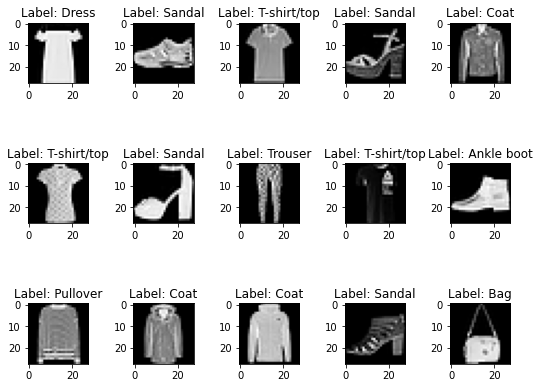

In [ ]:
print_white_black_image(train_x[:15],train_y[:15])

## Model

In [4]:
class CNN(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=32, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, padding=1)
        self.fc1 = nn.Linear(in_features=64 * 7 * 7, out_features=128)
        self.fc2 = nn.Linear(in_features=128, out_features=10)

    def forward(self, x):
        x = F.relu(F.max_pool2d(self.conv1(x), kernel_size=2, stride=2))
        x = F.relu(F.max_pool2d(self.conv2(x), kernel_size=2, stride=2))
        x = x.view(-1, 64 * 7 * 7)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x

In [ ]:
model = CNN()

In [ ]:
calculate_loss = nn.CrossEntropyLoss()
optimizer = Adam(model.parameters(), lr=0.01)

In [ ]:
len(train_set)

60000

In [ ]:
train_set, valid_set = random_split(train_set,[50000,10000])

In [ ]:
train_loader = torch.utils.data.DataLoader(
  train_set,
  batch_size=128, shuffle=True, num_workers=4)

valid_loader = torch.utils.data.DataLoader(
  valid_set,
  batch_size=128, shuffle=True, num_workers=4)

test_loader = torch.utils.data.DataLoader(
  test_set,
  batch_size=128, shuffle=True)

### Learning rate - 0.01

In [ ]:
num_iterations = 50
training_losses=[]
validation_losses=[]

for epoch in range(num_iterations):

  running_train_loss = 0.0
  for i, data in enumerate(train_loader, 0):
    inputs, labels = data
    optimizer.zero_grad()


    train_predictions = model(inputs)
    current_train_loss = calculate_loss(train_predictions, labels)
    current_train_loss.backward()
    optimizer.step()

    running_train_loss += current_train_loss.item()
  
  running_valid_loss = 0.0
  for i, data in enumerate(valid_loader, 0):
    inputs, labels = data
    valid_predictions = model(inputs)
    current_valid_loss = calculate_loss(valid_predictions, labels)
    running_valid_loss += current_valid_loss.item()


  print(f'[{epoch + 1}] training loss: {running_train_loss/4:.3f}, validation loss: {running_valid_loss:.3f}')
  training_losses.append(running_train_loss/4)
  validation_losses.append(running_valid_loss)

  PATH = f'./cifar_net_epoch_{epoch+1}.pth'
  torch.save(model.state_dict(), PATH)
  

print('Finished Training')

[1] training loss: 26.722, validation loss: 23.272
[2] training loss: 21.035, validation loss: 22.531
[3] training loss: 19.458, validation loss: 22.081
[4] training loss: 17.813, validation loss: 23.004
[5] training loss: 17.046, validation loss: 26.436
[6] training loss: 16.874, validation loss: 26.481
[7] training loss: 15.476, validation loss: 27.300
[8] training loss: 15.003, validation loss: 27.758
[9] training loss: 13.601, validation loss: 26.374
[10] training loss: 13.697, validation loss: 29.497
[11] training loss: 11.664, validation loss: 29.289
[12] training loss: 12.314, validation loss: 33.421
[13] training loss: 11.923, validation loss: 39.580
[14] training loss: 11.658, validation loss: 33.950
[15] training loss: 11.373, validation loss: 36.630
[16] training loss: 10.824, validation loss: 39.100
[17] training loss: 9.812, validation loss: 44.402
[18] training loss: 9.614, validation loss: 41.592
[19] training loss: 11.390, validation loss: 39.225
[20] training loss: 10.

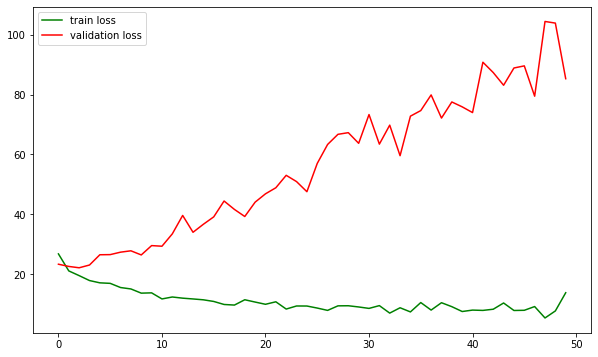

In [ ]:
plt.figure(figsize=(10, 6))
plt.plot(range(num_iterations), training_losses, color='green', label='train loss')
plt.plot(range(num_iterations), validation_losses, color='red', label='validation loss')
plt.legend()

In [ ]:
mean_training_losses =[]
mean_valid_losses = [] 
for i in range((int)(num_iterations/2)):
  mean_training_losses.append(sum(training_losses[i*2:i*2+2])/2)
  mean_valid_losses.append(sum(validation_losses[i*2:i*2+2])/2)

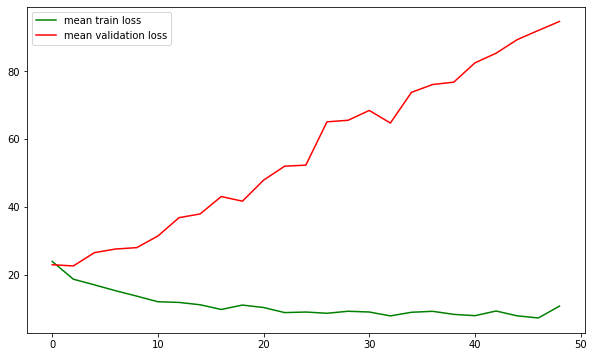

In [ ]:
plt.figure(figsize=(10, 6))
plt.plot(range(0,num_iterations,2), mean_training_losses, color='green', label='mean train loss')
plt.plot(range(0,num_iterations,2), mean_valid_losses, color='red', label='mean validation loss')
plt.legend()

We see that the model starts to overfit very quickly.

### Learning rate - 0.001

In [5]:
train_set=torchvision.datasets.FashionMNIST('./files/fashion-mnist/', train=True, download=True,
                             transform=transformer)

test_set=torchvision.datasets.FashionMNIST('./files/fashion-mnist/', train=False, download=True,
                             transform=transformer)

batch_size_train = 128
batch_size_test = 128

In [6]:
train_set, valid_set = random_split(train_set,[50000,10000])

In [7]:
train_loader = torch.utils.data.DataLoader(
  train_set,
  batch_size=128, shuffle=True, num_workers=4)

valid_loader = torch.utils.data.DataLoader(
  valid_set,
  batch_size=128, shuffle=True, num_workers=4)

test_loader = torch.utils.data.DataLoader(
  test_set,
  batch_size=128, shuffle=True)

In [9]:
model = CNN()
optimizer = Adam(model.parameters(), lr=0.001)
calculate_loss = nn.CrossEntropyLoss()

In [10]:
num_iterations = 30
training_losses=[]
validation_losses=[]

for epoch in range(num_iterations):

  running_train_loss = 0.0
  for i, data in enumerate(train_loader, 0):
    inputs, labels = data
    optimizer.zero_grad()


    train_predictions = model(inputs)
    current_train_loss = calculate_loss(train_predictions, labels)
    current_train_loss.backward()
    optimizer.step()

    running_train_loss += current_train_loss.item()
  
  running_valid_loss = 0.0
  for i, data in enumerate(valid_loader, 0):
    inputs, labels = data
    valid_predictions = model(inputs)
    current_valid_loss = calculate_loss(valid_predictions, labels)
    running_valid_loss += current_valid_loss.item()


  print(f'[{epoch + 1}] training loss: {running_train_loss/4:.3f}, validation loss: {running_valid_loss:.3f}')
  training_losses.append(running_train_loss/4)
  validation_losses.append(running_valid_loss)

  PATH = f'./cifar_net_epoch_{epoch+1}.pth'
  torch.save(model.state_dict(), PATH)
  

print('Finished Training')

[1] training loss: 53.120, validation loss: 29.460
[2] training loss: 33.327, validation loss: 24.644
[3] training loss: 28.786, validation loss: 22.470
[4] training loss: 25.509, validation loss: 21.089
[5] training loss: 23.330, validation loss: 20.243
[6] training loss: 21.209, validation loss: 20.186
[7] training loss: 19.536, validation loss: 19.342
[8] training loss: 17.925, validation loss: 19.969
[9] training loss: 16.400, validation loss: 17.890
[10] training loss: 14.970, validation loss: 18.794
[11] training loss: 13.773, validation loss: 17.992
[12] training loss: 12.561, validation loss: 19.251
[13] training loss: 11.036, validation loss: 20.049
[14] training loss: 10.008, validation loss: 18.518
[15] training loss: 8.837, validation loss: 19.114
[16] training loss: 7.971, validation loss: 21.439
[17] training loss: 6.754, validation loss: 21.339
[18] training loss: 6.287, validation loss: 24.524
[19] training loss: 5.281, validation loss: 23.156
[20] training loss: 4.542,

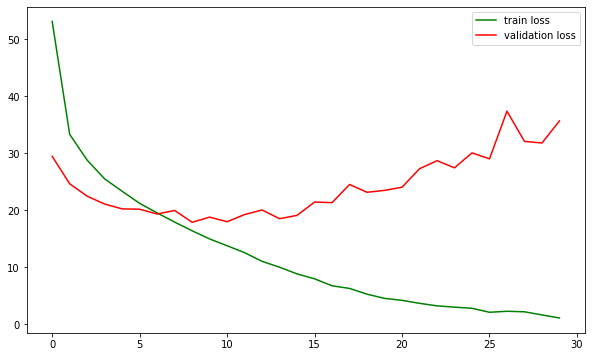

In [11]:
plt.figure(figsize=(10, 6))
plt.plot(range(num_iterations), training_losses, color='green', label='train loss')
plt.plot(range(num_iterations), validation_losses, color='red', label='validation loss')
plt.legend()

In [12]:
mean_training_losses =[]
mean_valid_losses = [] 
for i in range((int)(num_iterations/2)):
  mean_training_losses.append(sum(training_losses[i*2:i*2+2])/2)
  mean_valid_losses.append(sum(validation_losses[i*2:i*2+2])/2)

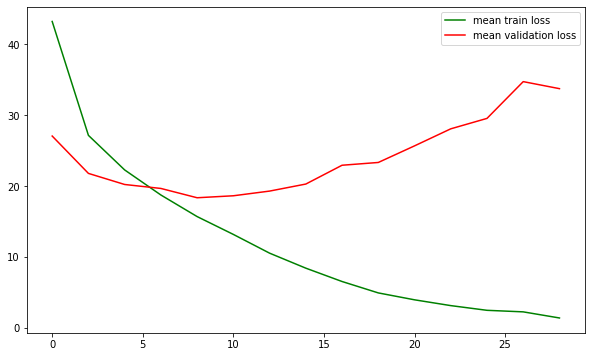

In [13]:
plt.figure(figsize=(10, 6))
plt.plot(range(0,num_iterations,2), mean_training_losses, color='green', label='mean train loss')
plt.plot(range(0,num_iterations,2), mean_valid_losses, color='red', label='mean validation loss')
plt.legend()

## Learning rate - 0.0001

In [14]:
model = CNN()
optimizer = Adam(model.parameters(), lr=0.0001)
calculate_loss = nn.CrossEntropyLoss()

In [15]:
num_iterations = 30
training_losses=[]
validation_losses=[]

for epoch in range(num_iterations):

  running_train_loss = 0.0
  for i, data in enumerate(train_loader, 0):
    inputs, labels = data
    optimizer.zero_grad()


    train_predictions = model(inputs)
    current_train_loss = calculate_loss(train_predictions, labels)
    current_train_loss.backward()
    optimizer.step()

    running_train_loss += current_train_loss.item()
  
  running_valid_loss = 0.0
  for i, data in enumerate(valid_loader, 0):
    inputs, labels = data
    valid_predictions = model(inputs)
    current_valid_loss = calculate_loss(valid_predictions, labels)
    running_valid_loss += current_valid_loss.item()


  print(f'[{epoch + 1}] training loss: {running_train_loss/4:.3f}, validation loss: {running_valid_loss:.3f}')
  training_losses.append(running_train_loss/4)
  validation_losses.append(running_valid_loss)

  PATH = f'./cifar_net_epoch_{epoch+1}.pth'
  torch.save(model.state_dict(), PATH)
  

print('Finished Training')

[1] training loss: 90.290, validation loss: 43.998
[2] training loss: 50.725, validation loss: 36.661
[3] training loss: 44.209, validation loss: 34.990
[4] training loss: 40.368, validation loss: 31.155
[5] training loss: 37.907, validation loss: 30.314
[6] training loss: 35.915, validation loss: 28.671
[7] training loss: 34.476, validation loss: 28.033
[8] training loss: 33.252, validation loss: 26.580
[9] training loss: 32.131, validation loss: 25.759
[10] training loss: 31.203, validation loss: 25.556
[11] training loss: 30.486, validation loss: 24.833
[12] training loss: 29.775, validation loss: 26.507
[13] training loss: 29.180, validation loss: 24.546
[14] training loss: 28.343, validation loss: 24.355
[15] training loss: 27.706, validation loss: 23.012
[16] training loss: 27.274, validation loss: 22.855
[17] training loss: 26.823, validation loss: 24.029
[18] training loss: 26.553, validation loss: 22.948
[19] training loss: 25.713, validation loss: 22.202
[20] training loss: 2

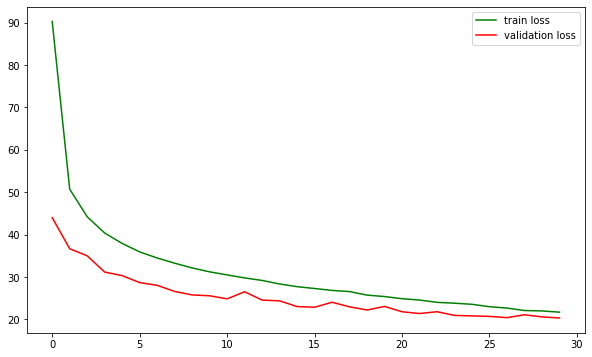

In [16]:
plt.figure(figsize=(10, 6))
plt.plot(range(num_iterations), training_losses, color='green', label='train loss')
plt.plot(range(num_iterations), validation_losses, color='red', label='validation loss')
plt.legend()

In [17]:
mean_training_losses =[]
mean_valid_losses = [] 
for i in range((int)(num_iterations/2)):
  mean_training_losses.append(sum(training_losses[i*2:i*2+2])/2)
  mean_valid_losses.append(sum(validation_losses[i*2:i*2+2])/2)

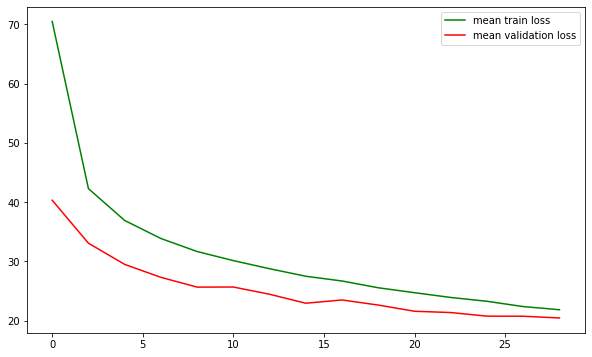

In [18]:
plt.figure(figsize=(10, 6))
plt.plot(range(0,num_iterations,2), mean_training_losses, color='green', label='mean train loss')
plt.plot(range(0,num_iterations,2), mean_valid_losses, color='red', label='mean validation loss')
plt.legend()

We can see that the NN does not overfit and there is still room for improvement. We will continue with the training.

In [19]:
for epoch in range(num_iterations):

  running_train_loss = 0.0
  for i, data in enumerate(train_loader, 0):
    inputs, labels = data
    optimizer.zero_grad()


    train_predictions = model(inputs)
    current_train_loss = calculate_loss(train_predictions, labels)
    current_train_loss.backward()
    optimizer.step()

    running_train_loss += current_train_loss.item()
  
  running_valid_loss = 0.0
  for i, data in enumerate(valid_loader, 0):
    inputs, labels = data
    valid_predictions = model(inputs)
    current_valid_loss = calculate_loss(valid_predictions, labels)
    running_valid_loss += current_valid_loss.item()


  print(f'[{epoch + 31}] training loss: {running_train_loss/4:.3f}, validation loss: {running_valid_loss:.3f}')
  training_losses.append(running_train_loss/4)
  validation_losses.append(running_valid_loss)

  PATH = f'./cifar_net_epoch_{epoch+31}.pth'
  torch.save(model.state_dict(), PATH)
  

print('Finished Training')

[31] training loss: 21.359, validation loss: 19.856
[32] training loss: 21.005, validation loss: 19.838
[33] training loss: 20.708, validation loss: 19.358
[34] training loss: 20.356, validation loss: 21.500
[35] training loss: 20.148, validation loss: 19.304
[36] training loss: 19.809, validation loss: 19.916
[37] training loss: 19.587, validation loss: 19.412
[38] training loss: 19.394, validation loss: 19.540
[39] training loss: 18.908, validation loss: 19.677
[40] training loss: 18.877, validation loss: 19.461
[41] training loss: 18.537, validation loss: 18.859
[42] training loss: 18.414, validation loss: 19.139
[43] training loss: 18.197, validation loss: 19.022
[44] training loss: 17.791, validation loss: 18.949
[45] training loss: 17.419, validation loss: 19.344
[46] training loss: 17.572, validation loss: 18.896
[47] training loss: 17.047, validation loss: 18.590
[48] training loss: 17.072, validation loss: 18.093
[49] training loss: 16.724, validation loss: 18.699
[50] trainin

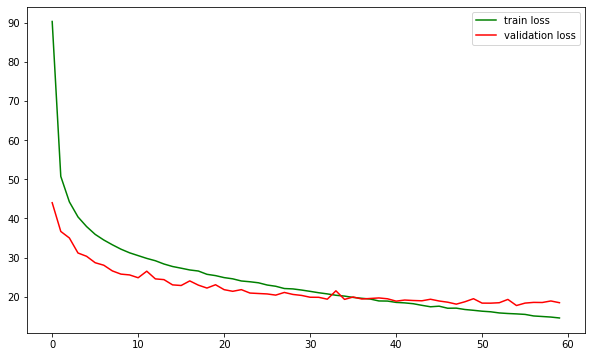

In [20]:
plt.figure(figsize=(10, 6))
plt.plot(range(2*num_iterations), training_losses, color='green', label='train loss')
plt.plot(range(2*num_iterations), validation_losses, color='red', label='validation loss')
plt.legend()

In [23]:
mean_training_losses =[]
mean_valid_losses = [] 
for i in range(num_iterations):
  mean_training_losses.append(sum(training_losses[i*2:i*2+2])/2)
  mean_valid_losses.append(sum(validation_losses[i*2:i*2+2])/2)

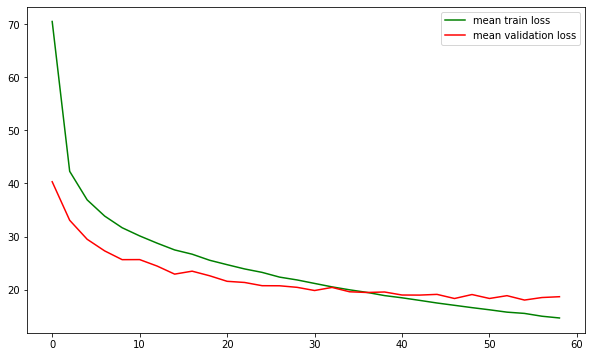

In [24]:
plt.figure(figsize=(10, 6))
plt.plot(range(0,2*num_iterations,2), mean_training_losses, color='green', label='mean train loss')
plt.plot(range(0,2*num_iterations,2), mean_valid_losses, color='red', label='mean validation loss')
plt.legend()

The model starts to overfit a little bit but there is a chance that this is just a local minimum and that after a fex epochs the validation score will fall even more. We will train the model for another 20 epochs and then we will get the best parameters.

In [25]:
for epoch in range(20):

  running_train_loss = 0.0
  for i, data in enumerate(train_loader, 0):
    inputs, labels = data
    optimizer.zero_grad()


    train_predictions = model(inputs)
    current_train_loss = calculate_loss(train_predictions, labels)
    current_train_loss.backward()
    optimizer.step()

    running_train_loss += current_train_loss.item()
  
  running_valid_loss = 0.0
  for i, data in enumerate(valid_loader, 0):
    inputs, labels = data
    valid_predictions = model(inputs)
    current_valid_loss = calculate_loss(valid_predictions, labels)
    running_valid_loss += current_valid_loss.item()


  print(f'[{epoch + 61}] training loss: {running_train_loss/4:.3f}, validation loss: {running_valid_loss:.3f}')
  training_losses.append(running_train_loss/4)
  validation_losses.append(running_valid_loss)

  PATH = f'./cifar_net_epoch_{epoch+61}.pth'
  torch.save(model.state_dict(), PATH)
  

print('Finished Training')

[61] training loss: 14.384, validation loss: 19.361
[62] training loss: 14.250, validation loss: 17.939
[63] training loss: 14.008, validation loss: 18.870
[64] training loss: 13.806, validation loss: 18.114
[65] training loss: 13.652, validation loss: 17.964
[66] training loss: 13.393, validation loss: 18.931
[67] training loss: 13.335, validation loss: 18.244
[68] training loss: 13.248, validation loss: 18.803
[69] training loss: 12.928, validation loss: 17.890
[70] training loss: 12.800, validation loss: 17.870
[71] training loss: 12.683, validation loss: 18.399
[72] training loss: 12.456, validation loss: 17.982
[73] training loss: 12.216, validation loss: 18.155
[74] training loss: 12.189, validation loss: 18.062
[75] training loss: 11.974, validation loss: 18.142
[76] training loss: 11.769, validation loss: 18.359
[77] training loss: 11.614, validation loss: 19.045
[78] training loss: 11.403, validation loss: 18.294
[79] training loss: 11.214, validation loss: 18.458
[80] trainin

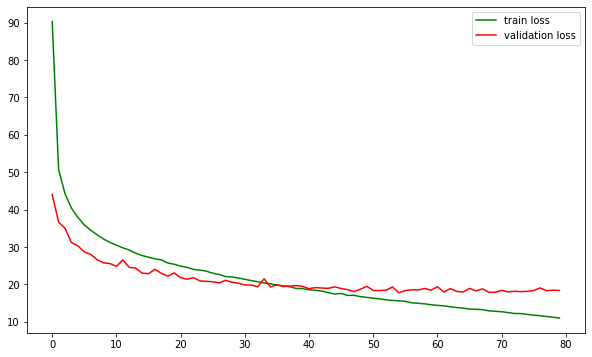

In [26]:
plt.figure(figsize=(10, 6))
plt.plot(range(2*num_iterations+20), training_losses, color='green', label='train loss')
plt.plot(range(2*num_iterations+20), validation_losses, color='red', label='validation loss')
plt.legend()

In [30]:
mean_training_losses =[]
mean_valid_losses = [] 
for i in range(num_iterations+10):
  mean_training_losses.append(sum(training_losses[i*2:i*2+2])/2)
  mean_valid_losses.append(sum(validation_losses[i*2:i*2+2])/2)

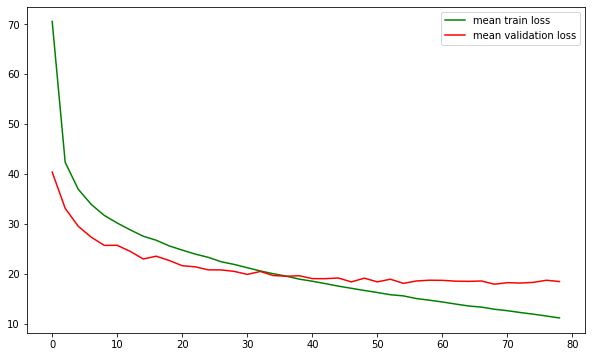

In [31]:
plt.figure(figsize=(10, 6))
plt.plot(range(0,2*num_iterations+20,2), mean_training_losses, color='green', label='mean train loss')
plt.plot(range(0,2*num_iterations+20,2), mean_valid_losses, color='red', label='mean validation loss')
plt.legend()

We see that it starts to overfit after the 60th epoch and the best results are from teh 55th epoch.

In [32]:
PATH = f'./cifar_net_epoch_55.pth'

In [33]:
cnn = CNN()
cnn.load_state_dict(torch.load(PATH))

<All keys matched successfully>

In [34]:
PATH = 'final_cnn.pth'

In [35]:
torch.save(cnn.state_dict(), PATH)

In [43]:
with torch.no_grad():
    cnn.eval()
    predictions = []
    ground_truth = []
    for images, labels in test_loader:
        images, labels = data
        outputs = cnn(images)
        _, predicted = torch.max(outputs.data, 1)
        predictions.extend(predicted.numpy())
        ground_truth.extend(labels.numpy())
    
    f1 = f1_score(ground_truth, predictions, average='macro')
    print (f'CNN F1 score on test data = {f1_score(ground_truth, predictions,average="micro")*100}')
    print (f'CNN Classification Report \n {classification_report(ground_truth, predictions, labels=range(0,10))}')

CNN F1 score on test data = 93.75
CNN Classification Report 
               precision    recall  f1-score   support

           0       1.00      1.00      1.00        79
           1       0.00      0.00      0.00         0
           2       1.00      0.50      0.67       158
           3       1.00      1.00      1.00       158
           4       0.67      1.00      0.80       158
           5       1.00      1.00      1.00        79
           6       0.00      0.00      0.00         0
           7       1.00      1.00      1.00       158
           8       1.00      1.00      1.00       237
           9       1.00      1.00      1.00       237

   micro avg       0.94      0.94      0.94      1264
   macro avg       0.77      0.75      0.75      1264
weighted avg       0.96      0.94      0.93      1264



In [48]:
correct_pred = {classname: 0 for classname in classes}
total_pred = {classname: 0 for classname in classes}
predictions = []
test_y = []

with torch.no_grad():
    cnn.eval()
    for data in test_loader:
        images, labels = data
        outputs = cnn(images)
        _, predict = torch.max(outputs, 1)
        for label, prediction in zip(labels, predict):
            if label == prediction:
                correct_pred[classes[label]] += 1
            total_pred[classes[label]] += 1
            predictions.append(prediction)
            test_y.append(label)


for classname, correct_count in correct_pred.items():
    accuracy = 100 * float(correct_count) / total_pred[classname]
    print(f'Accuracy for class: {classname:5s} is {accuracy:.1f} %')

Accuracy for class: T-shirt/top is 90.1 %
Accuracy for class: Trouser is 97.9 %
Accuracy for class: Pullover is 88.0 %
Accuracy for class: Dress is 91.3 %
Accuracy for class: Coat  is 87.6 %
Accuracy for class: Sandal is 98.0 %
Accuracy for class: Shirt is 69.0 %
Accuracy for class: Sneaker is 97.4 %
Accuracy for class: Bag   is 98.3 %
Accuracy for class: Ankle boot is 96.1 %


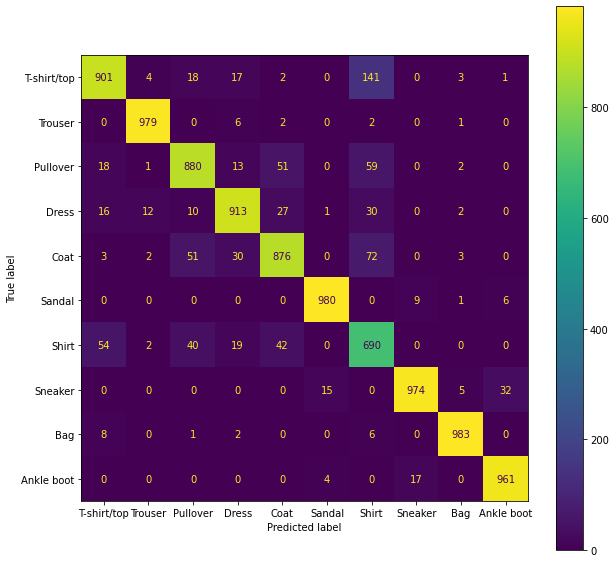

In [70]:
cm = confusion_matrix(predictions,test_y)
disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                              display_labels=classes)
fig = plt.figure(figsize=(10, 10))
disp.plot(ax=fig.gca())
plt.show()

## Conclusion

The results of the CNN are pretty good. The F1 score is 93.75.